In [1]:
# Cell 1: Data Loading, Preprocessing, and Stratified Group Split
import pandas as pd
import numpy as np
from collections import defaultdict

# 1. Load the dataset, force Sample and AB as strings to avoid mixed types
df = pd.read_csv(
    './data300.csv',
    dtype={'Sample': str, 'AB': str},
    low_memory=False,
)
df['Sample'] = df['Sample'].astype(str)

# --- Normalize the Group column to exactly "Neg", "Pos", or "Fungi" ---
# 1) lower‐case and strip whitespace
df['Group'] = df['Group'].str.strip().str.lower()

# 2) map every variant you have to our three canonical keys
df['Group'] = df['Group'].map({
    'neg': 'Neg',
    'gram‐negative': 'Neg',
    'gram-negative bacteria': 'Neg',
    'pos': 'Pos',
    'gram‐positive': 'Pos',
    'gram-positive bacteria': 'Pos',
    'yeast': 'Fungi',           # <-- your “fungi” are tagged as “Yeast”
    'fungi': 'Fungi',           # in case any got through
})

# sanity check
print("Normalized groups:", df['Group'].unique())

# 2. Identify intensity columns (first 5 columns are metadata)
intensity_cols = df.columns[5:]

# 3. Min-max normalize each spectrum (each row) across the intensity columns
X_values = df[intensity_cols].to_numpy(dtype=np.float32)
mins = X_values.min(axis=1, keepdims=True)
maxs = X_values.max(axis=1, keepdims=True)
ranges = np.where(maxs - mins == 0, 1.0, maxs - mins)
X_norm = (X_values - mins) / ranges  # shape (N, num_wavelengths)

# 4. Encode species labels into integer classes
species_labels = df['ID'].astype(str).values
unique_species = sorted(np.unique(species_labels))
label_to_idx = {lab: i for i, lab in enumerate(unique_species)}
y_full = np.array([label_to_idx[s] for s in species_labels], dtype=np.int64)

# 5. Build a unique sample key per biological sample: "<Species>_<SampleID>"
df['sample_key'] = df['ID'].astype(str) + '_' + df['Sample'].astype(str)

# 6. Stratified selection of one sample_key per species for the test set
species_to_keys = defaultdict(list)
for key, species in zip(df['sample_key'], df['ID']):
    species_to_keys[species].append(key)

np.random.seed(11)
test_keys = []
for species, keys in species_to_keys.items():
    if len(keys) >= 2:
        # randomly select one key for test
        test_keys.append(np.random.choice(keys))
    # species with only one sample_key remain in train/val

# 7. Remaining keys for train+val
all_keys = set(df['sample_key'])
train_val_keys = list(all_keys - set(test_keys))
np.random.shuffle(train_val_keys)

# 8. Split train+val keys into 80% train, 20% val
n_train_val = len(train_val_keys)
n_train = int(0.8 * n_train_val)
train_keys = train_val_keys[:n_train]
val_keys   = train_val_keys[n_train:]

# 9. Build boolean masks for each split based on sample_key
train_mask = df['sample_key'].isin(train_keys)
val_mask   = df['sample_key'].isin(val_keys)
test_mask  = df['sample_key'].isin(test_keys)

# 10. Slice out X and y for each split
X_train, y_train = X_norm[train_mask], y_full[train_mask]
X_val,   y_val   = X_norm[val_mask],   y_full[val_mask]
X_test,  y_test  = X_norm[test_mask],  y_full[test_mask]

# 11. Sanity checks: counts and species coverage
print(f"Total spectra: {len(df)}")
print(f"Train spectra: {X_train.shape[0]}, Val spectra: {X_val.shape[0]}, Test spectra: {X_test.shape[0]}")

# Count per species in each split
import pandas as pd
train_counts = pd.Series(y_train).map(lambda i: unique_species[i]).value_counts()
val_counts   = pd.Series(y_val).map(lambda i: unique_species[i]).value_counts()
test_counts  = pd.Series(y_test).map(lambda i: unique_species[i]).value_counts()

print("\nTrain set species counts:\n", train_counts)
print("\nVal set species counts:\n", val_counts)
print("\nTest set species counts:\n", test_counts)

Normalized groups: ['Neg' 'Fungi' 'Pos']
Total spectra: 102600
Train spectra: 73200, Val spectra: 18600, Test spectra: 10800

Train set species counts:
 Eco     5400
Kox     3900
CaTr    3900
Ano     3300
Api     3300
CaKr    3000
CrNe    3000
CaGu    2700
CaAl    2700
CaGl    2400
Efa     2400
CaPa    2100
Ecl     2100
Aba     2100
Mmo     2100
Kpn     1800
Sep     1800
Eae     1800
Cfr     1800
Efm     1800
Pae     1500
Sho     1500
Sma     1500
Cdi     1500
Bce     1500
Shl     1500
Sca     1500
Pmi     1500
Svi     1500
Sgc     1500
Spn     1200
Bfg      900
Sau      900
Stm      600
Sal      600
Lmo      600
Name: count, dtype: int64

Val set species counts:
 Stm     1500
CaPa    1500
CaGl    1200
CaAl    1200
Api     1200
CaGu     900
Ano      900
Efa      900
CaKr     900
Sau      900
CrNe     600
Bfg      600
Sal      600
Pmi      600
Sma      600
Lmo      600
Eae      300
Pae      300
Cfr      300
Cdi      300
Bce      300
Shl      300
Sgc      300
Sca      300
Sho      300
Sv

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader

class RamanSpectraDataset(Dataset):
    def __init__(self, X, y, augment=False):
        """
        X: numpy array (N, seq_len)
        y: numpy array (N,)
        augment: bool, whether to apply on-the-fly spectral augmentation
        """
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).long()
        self.augment = augment

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        spec = self.X[idx].clone()  # shape (seq_len,)

        if self.augment:
            # 1) Random Gaussian noise (σ=0.01)
            if torch.rand(1).item() < 0.5:
                spec += 0.01 * torch.randn_like(spec)
            # 2) Random shift ±5
            if torch.rand(1).item() < 0.5:
                shift = int(torch.randint(-5, 6, (1,)).item())
                spec = torch.roll(spec, shifts=shift, dims=0)
            # 3) Random scaling [0.9,1.1]
            if torch.rand(1).item() < 0.5:
                scale = float(torch.empty(1).uniform_(0.9,1.1))
                spec *= scale
            # 4) Small baseline drift
            if torch.rand(1).item() < 0.3:
                drift = torch.linspace(0, float(torch.randn(1)), spec.size(0))
                spec += drift
            spec = spec.clamp(0.0, 1.0)

        return spec, self.y[idx]

# Now build your loaders
batch_size = 256

# Training set with augmentation
train_ds = RamanSpectraDataset(X_train, y_train, augment=True)
train_loader = DataLoader(
    train_ds,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

# Validation & test without augmentation
val_ds = RamanSpectraDataset(X_val, y_val, augment=False)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False,
                        num_workers=4, pin_memory=True)

test_ds = RamanSpectraDataset(X_test, y_test, augment=False)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False,
                         num_workers=4, pin_memory=True)


In [3]:
import torch
import torch.nn as nn
import math
from torch.utils.data import Dataset, DataLoader

class RamanTransformerClassifier(nn.Module):
    def __init__(self, seq_len, num_classes, d_model=64, nhead=8, dim_feedforward=256, num_layers=2, dropout=0.1):
        """
        Initializes the Transformer-based classifier.
        seq_len: length of the input sequence (number of wavelength points, e.g., 1000)
        num_classes: number of output classes (species)
        d_model: dimensionality of the embedding/transformer model
        nhead: number of heads in multi-head attention
        dim_feedforward: dimensionality of the feedforward network in transformer layers
        num_layers: number of transformer encoder layers
        dropout: dropout rate for transformer layers
        """
        super(RamanTransformerClassifier, self).__init__()
        # Linear projection of input scalar to d_model-dimensional embedding
        self.value_embedding = nn.Linear(1, d_model)
        # Positional encoding (sinusoidal)
        pos_encoding = torch.zeros(seq_len, d_model)
        positions = torch.arange(0, seq_len, dtype=torch.float32).unsqueeze(1)  # shape [seq_len, 1]
        # Frequencies for sine/cosine positional encoding
        div_term = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float32) * -(math.log(10000.0) / d_model))
        pos_encoding[:, 0::2] = torch.sin(positions * div_term)  # apply sin to even indices in the embedding
        pos_encoding[:, 1::2] = torch.cos(positions * div_term)  # apply cos to odd indices
        pos_encoding = pos_encoding.unsqueeze(0)  # shape [1, seq_len, d_model] for broadcasting
        # Register as buffer (not a parameter, but part of the state for usage)
        self.register_buffer('pos_encoding', pos_encoding)

        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, 
                                                  dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Classification head
        self.classifier = nn.Linear(d_model, num_classes)
    
    def forward(self, x):
        """
        Forward pass for the model.
        x: input tensor of shape [batch_size, seq_len] containing normalized Raman intensities.
        """
        # Project each intensity value to a d_model-dimensional embedding
        # x is [batch, seq_len]; convert to [batch, seq_len, 1] for linear layer
        x = x.unsqueeze(-1)
        x = self.value_embedding(x)  # now x shape: [batch, seq_len, d_model]

        # Add positional encoding to include wavelength position information
        x = x + self.pos_encoding[:, :x.size(1), :]  # broadcasting over batch dimension

        # Pass through Transformer encoder layers
        x = self.transformer_encoder(x)  # shape remains [batch, seq_len, d_model]

        # Global average pooling over the sequence dimension
        x = x.mean(dim=1)  # shape: [batch, d_model]

        # Final classifier to get class logits
        logits = self.classifier(x)  # shape: [batch, num_classes]

        return logits

# Initialize the model
seq_length = X_train.shape[1]  # this should be 1000 (number of wavelength points)
num_classes = len(unique_species)
model = RamanTransformerClassifier(
    seq_len=seq_length,                                   
    num_classes=num_classes,                                   
    d_model=128,                                    
    nhead=8,                                    
    dim_feedforward=512,                                   
    num_layers=4, 
    dropout=0.3)

print(model)


RamanTransformerClassifier(
  (value_embedding): Linear(in_features=1, out_features=128, bias=True)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=512, bias=True)
        (dropout): Dropout(p=0.3, inplace=False)
        (linear2): Linear(in_features=512, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.3, inplace=False)
        (dropout2): Dropout(p=0.3, inplace=False)
      )
    )
  )
  (classifier): Linear(in_features=128, out_features=36, bias=True)
)


In [4]:
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler

# 0) Device and move model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)
model.to(device)

# 1) DataLoaders using on-the-fly augmentation
batch_size = 256

train_ds = RamanSpectraDataset(X_train, y_train, augment=True)
val_ds   = RamanSpectraDataset(X_val,   y_val,   augment=False)
test_ds  = RamanSpectraDataset(X_test,  y_test,  augment=False)

# 1) Compute per-class weights inversely proportional to counts
class_counts = np.bincount(y_train)               # [n_neg, n_pos, ...]
class_weights = 1.0 / class_counts
sample_weights = class_weights[y_train]            # weight per example

# 2) Build a sampler that will up-sample rare classes
sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),              # keeps same dataset size
    replacement=True
)

train_loader = DataLoader(
    train_ds,
    batch_size=batch_size,
    sampler=sampler,
    num_workers=4,
    pin_memory=True
)
val_loader = DataLoader(
    val_ds,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)
test_loader = DataLoader(
    test_ds,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

# 2) Optimizer, scheduler, loss
learning_rate = 5e-4
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=3e-4)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# 3) Training hyperparams
num_epochs = 100
patience   = 15

# 4) Seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)

# 5) Metric containers & early‐stop tracking
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
best_val_acc = 0.0
best_model_state = None
epochs_no_improve = 0


Using device: cuda


In [5]:
%%time
import math
import torch

# ——————————————————————————————————————————————————————————————————————————
# 0) Assumes you’ve already run the cell that defines:
#    • RamanSpectraDataset
#    • X_train, y_train, X_val, y_val, X_test, y_test
#    • Device and model moved to device
#    • optimizer and criterion defined
# ——————————————————————————————————————————————————————————————————————————

# 1) (Re)build DataLoaders here with augmentation on train only
batch_size = 256
train_ds = RamanSpectraDataset(X_train, y_train, augment=True)
val_ds   = RamanSpectraDataset(X_val,   y_val,   augment=False)
test_ds  = RamanSpectraDataset(X_test,  y_test,  augment=False)

train_loader = torch.utils.data.DataLoader(
    train_ds, batch_size=batch_size, sampler=sampler,
    num_workers=0, pin_memory=True
)
val_loader = torch.utils.data.DataLoader(
    val_ds, batch_size=batch_size, shuffle=False,
    num_workers=0, pin_memory=True
)
test_loader = torch.utils.data.DataLoader(
    test_ds, batch_size=batch_size, shuffle=False,
    num_workers=0, pin_memory=True
)

# 2) Compute total_steps and warmup
total_steps = len(train_loader) * num_epochs
warmup_steps = int(0.1 * total_steps)

def lr_lambda(step):
    if step < warmup_steps:
        return step / warmup_steps
    progress = (step - warmup_steps) / max(1, total_steps - warmup_steps)
    return 0.5 * (1 + math.cos(math.pi * progress))

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

# 3) Training loop
global_step = 0
best_val_acc = 0.0
epochs_no_improve = 0

for epoch in range(1, num_epochs+1):
    # — Training —
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        logits = model(X_batch)
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()
        scheduler.step()       # step LR every batch
        global_step += 1

        # metrics
        train_loss   += loss.item() * X_batch.size(0)
        preds         = logits.argmax(dim=1)
        train_correct += (preds == y_batch).sum().item()
        train_total  += y_batch.size(0)

    avg_train_loss = train_loss / train_total
    train_acc      = train_correct / train_total

    # — Validation —
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            logits = model(X_batch)
            loss = criterion(logits, y_batch)
            val_loss    += loss.item() * X_batch.size(0)
            preds        = logits.argmax(dim=1)
            val_correct += (preds == y_batch).sum().item()
            val_total   += y_batch.size(0)

    avg_val_loss = val_loss / val_total
    val_acc      = val_correct / val_total

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch:02d} | "
          f"Train Loss={avg_train_loss:.4f}, Acc={train_acc*100:.1f}% | "
          f"Val Loss={avg_val_loss:.4f}, Acc={val_acc*100:.1f}% | "
          f"LR={current_lr:.2e}")

    # — Early stopping on val_acc —
    if val_acc > best_val_acc:
        best_val_acc     = val_acc
        best_model_state = model.state_dict()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"No improvement in {patience} epochs. Stopping early.")
            break

# restore best model
model.load_state_dict(best_model_state)
print(f"Loaded best model (Val Acc = {best_val_acc*100:.2f}%)")


Epoch 01 | Train Loss=3.5974, Acc=3.4% | Val Loss=3.5796, Acc=2.9% | LR=5.00e-05
Epoch 02 | Train Loss=3.5156, Acc=6.7% | Val Loss=3.3104, Acc=10.7% | LR=1.00e-04
Epoch 03 | Train Loss=2.8460, Acc=23.0% | Val Loss=2.2018, Acc=40.2% | LR=1.50e-04
Epoch 04 | Train Loss=2.1120, Acc=45.0% | Val Loss=1.7828, Acc=56.9% | LR=2.00e-04
Epoch 05 | Train Loss=1.7885, Acc=56.5% | Val Loss=1.7313, Acc=58.7% | LR=2.50e-04
Epoch 06 | Train Loss=1.6216, Acc=63.0% | Val Loss=1.6178, Acc=65.8% | LR=3.00e-04
Epoch 07 | Train Loss=1.5132, Acc=67.2% | Val Loss=1.6464, Acc=66.4% | LR=3.50e-04
Epoch 08 | Train Loss=1.4139, Acc=71.2% | Val Loss=1.7590, Acc=67.1% | LR=4.00e-04
Epoch 09 | Train Loss=1.3433, Acc=74.3% | Val Loss=1.6952, Acc=68.6% | LR=4.50e-04
Epoch 10 | Train Loss=1.2952, Acc=76.1% | Val Loss=1.6588, Acc=70.6% | LR=5.00e-04
Epoch 11 | Train Loss=1.2404, Acc=78.3% | Val Loss=1.7922, Acc=69.8% | LR=5.00e-04
Epoch 12 | Train Loss=1.1977, Acc=79.8% | Val Loss=1.6886, Acc=72.7% | LR=4.99e-04
Epoch 1

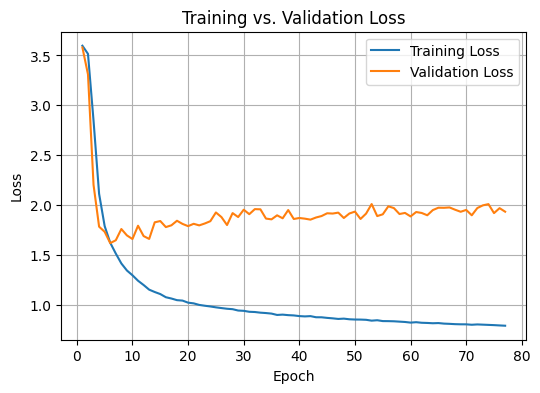

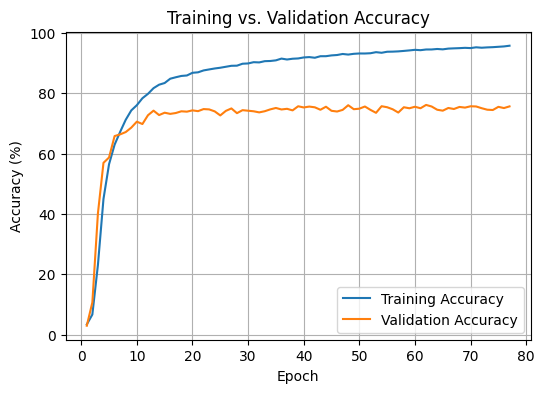

In [6]:
import matplotlib.pyplot as plt

epochs_ran = len(train_losses)  # total epochs that ran (could be less than num_epochs if early stopped)
epoch_range = range(1, epochs_ran+1)

# Plot Training and Validation Loss
plt.figure(figsize=(6,4))
plt.plot(epoch_range, train_losses, label='Training Loss')
plt.plot(epoch_range, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot Training and Validation Accuracy
plt.figure(figsize=(6,4))
plt.plot(epoch_range, np.array(train_accuracies)*100, label='Training Accuracy')
plt.plot(epoch_range, np.array(val_accuracies)*100, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training vs. Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()


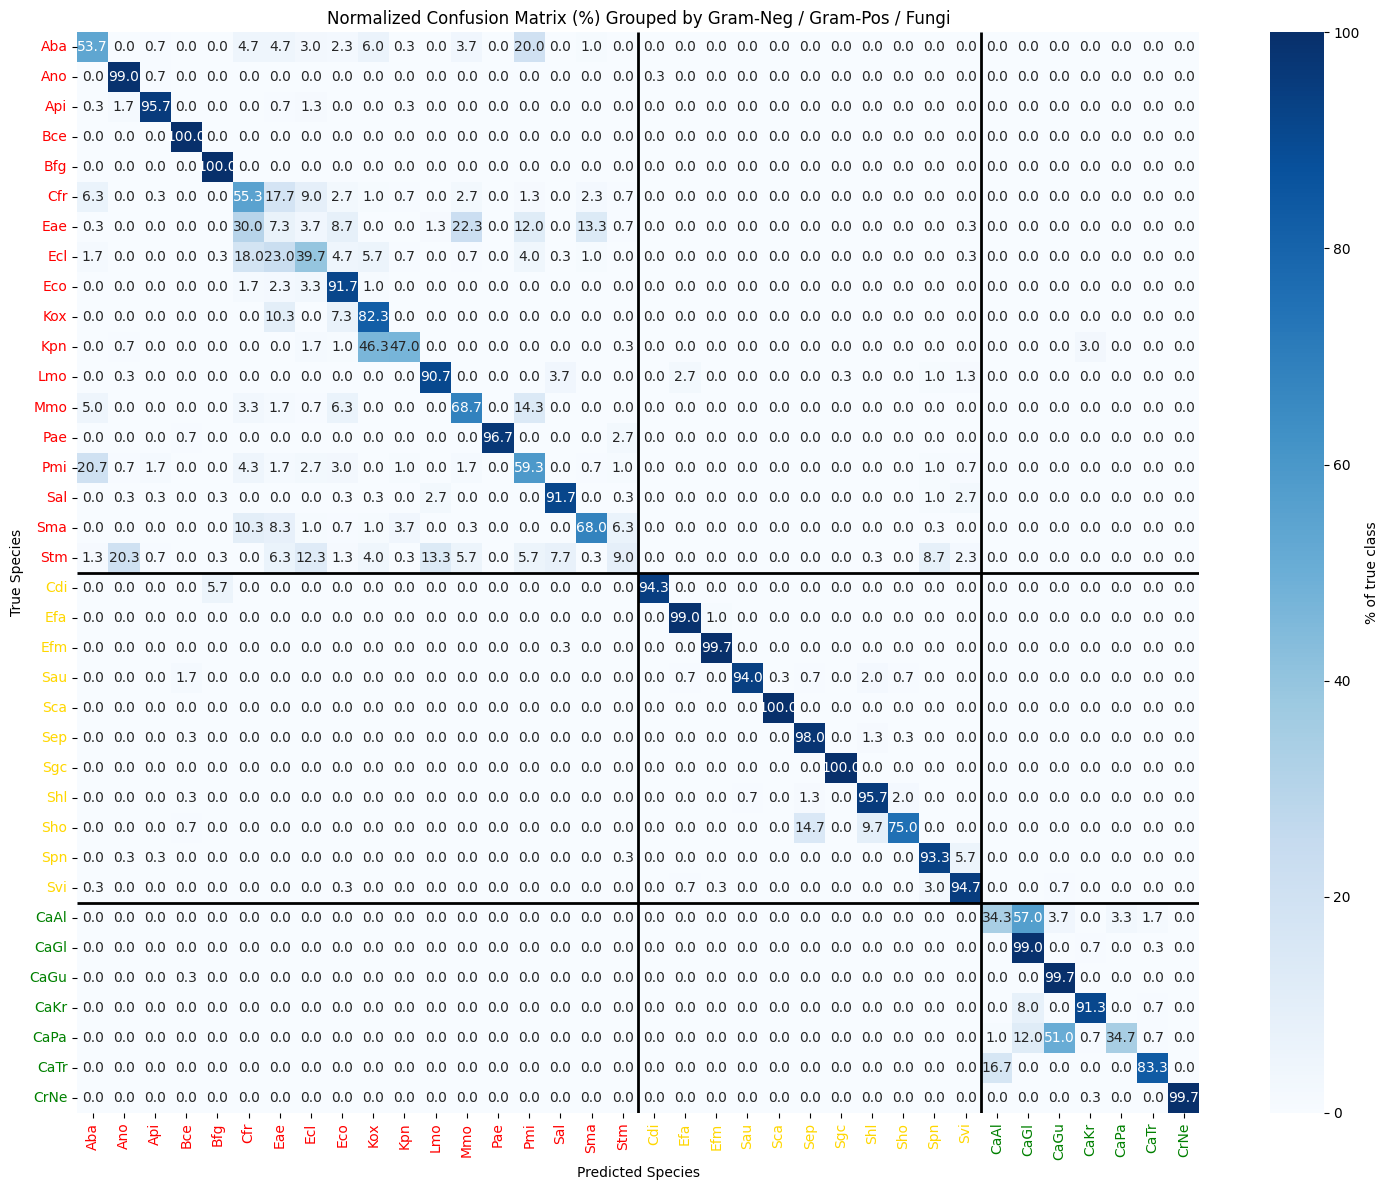

Test Accuracy: 78.93% (8524/10800)


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Make sure model is in eval mode}
model.eval()

# Collect true & predicted labels on the test set
y_true = []
y_pred = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        preds = outputs.argmax(dim=1).cpu().numpy()
        y_pred.extend(preds)
        # y_batch comes off the loader on CPU
        y_true.extend(y_batch.numpy())

y_true = np.array(y_true, dtype=int)
y_pred = np.array(y_pred, dtype=int)

# Build a species->group map
species_group_map = df.drop_duplicates('ID').set_index('ID')['Group'].to_dict()

# Order and colors
group_order  = ['Neg','Pos','Fungi']
group_colors = {'Neg':'red','Pos':'gold','Fungi':'green'}

# Create the ordered species list
species_ordered = [
    sp
    for grp in group_order
    for sp in unique_species
    if species_group_map[sp] == grp
]

# Compute and normalize the confusion matrix
cm_counts = confusion_matrix(y_true, y_pred, labels=np.arange(len(unique_species)))
row_sums  = cm_counts.sum(axis=1, keepdims=True)
cm_pct    = np.nan_to_num(cm_counts / row_sums * 100)  # fill 0/0 with 0

# Reorder rows & columns
idx       = [unique_species.index(sp) for sp in species_ordered]
cm_pct    = cm_pct[np.ix_(idx, idx)]

# Plot
fig, ax = plt.subplots(figsize=(15,12))
sns.heatmap(
    cm_pct,
    annot=True,
    fmt=".1f",
    cmap="Blues",
    xticklabels=species_ordered,
    yticklabels=species_ordered,
    cbar_kws={'label':'% of true class'},
    ax=ax
)

# Color tick labels by group
plt.xticks(rotation=90)
plt.yticks(rotation=0)
for lbl in ax.get_xticklabels():
    lbl.set_color(group_colors[species_group_map[lbl.get_text()]])
for lbl in ax.get_yticklabels():
    lbl.set_color(group_colors[species_group_map[lbl.get_text()]])

# Draw separators between Neg/Pos/Fungi blocks
neg_end = sum(1 for sp in species_ordered if species_group_map[sp]=='Neg')
pos_end = neg_end + sum(1 for sp in species_ordered if species_group_map[sp]=='Pos')
ax.hlines([neg_end, pos_end], *ax.get_xlim(), colors='black', linewidth=2)
ax.vlines([neg_end, pos_end], *ax.get_ylim(), colors='black', linewidth=2)

# Labels & title
ax.set_xlabel("Predicted Species")
ax.set_ylabel("True Species")
ax.set_title("Normalized Confusion Matrix (%) Grouped by Gram-Neg / Gram-Pos / Fungi")
plt.tight_layout()
plt.show()

# 2) Iterate over test set and accumulate correct / total
correct = 0
total   = 0

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        logits = model(X_batch)
        preds  = logits.argmax(dim=1)
        correct += (preds == y_batch).sum().item()
        total   += y_batch.size(0)

# 3) Compute and print test accuracy
test_acc = correct / total * 100
print(f"Test Accuracy: {test_acc:.2f}% ({correct}/{total})")

In [8]:
import torch, gc

# 2) Delete big objects
for name in ['model', 'optimizer', 'scheduler', 
             'train_loader', 'val_loader', 'test_loader',
             'train_ds', 'val_ds', 'test_ds']:
    if name in globals():
        del globals()[name]

# 3) Force garbage collection
gc.collect()

# 4) Empty PyTorch CUDA cache
torch.cuda.empty_cache()

print("Freed GPU memory; current allocated:", torch.cuda.memory_allocated(), 
      "cached:", torch.cuda.memory_reserved())


Freed GPU memory; current allocated: 20951552 cached: 553648128
